In [176]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import os

In [177]:
# re-size all the images to this
IMAGE_SIZE = [48, 48] # feel free to change depending on dataset

In [178]:
# training config:
epochs = 100
batch_size = 32

In [179]:
train_path = 'train'
valid_path = 'test'

In [180]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
# print(image_files)

In [181]:
# useful for getting number of classes
folders = glob(train_path + '/*')
print(folders)

['train\\Bu_anil', 'train\\Chwi_gajil', 'train\\Eeo_eojosa', 'train\\Ga_olheul', 'train\\Gyeong_byeoseul', 'train\\Ha_alae', 'train\\Ha_eojji', 'train\\Il_han', 'train\\I_sseo', 'train\\Ji_al', 'train\\Ji_gal', 'train\\Mu_eobseul', 'train\\Wi_hal', 'train\\Yu_isseul']


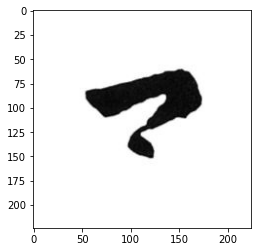

In [182]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [183]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [184]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [185]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(units=32,activation="relu")(x)
x = Dense(units=32,activation="relu")(x)

In [186]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [187]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [188]:
# view the structure of the model
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [189]:

# tell the model what cost and optimization method to use
# optimizer: RMSprop, Adam
model.compile(
  loss='categorical_crossentropy',
  optimizer='Adam',
  metrics=['accuracy']
)

In [190]:

# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  
  width_shift_range=0.1,
  height_shift_range=-0.1,
  zoom_range=0.2,
  horizontal_flip=False,
  vertical_flip=False,
  preprocessing_function=preprocess_input
)

In [191]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 711 images belonging to 14 classes.
{'Bu_anil': 0, 'Chwi_gajil': 1, 'Eeo_eojosa': 2, 'Ga_olheul': 3, 'Gyeong_byeoseul': 4, 'Ha_alae': 5, 'Ha_eojji': 6, 'I_sseo': 7, 'Il_han': 8, 'Ji_al': 9, 'Ji_gal': 10, 'Mu_eobseul': 11, 'Wi_hal': 12, 'Yu_isseul': 13}


min: -79.8177 max: 151.061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


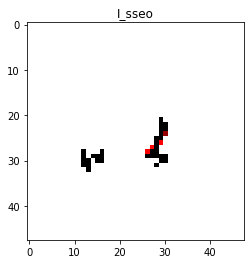

In [192]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [193]:

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 2835 images belonging to 14 classes.


In [194]:

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 711 images belonging to 14 classes.


In [195]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

C:\Users\SeonminKim\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
88/88 [==============================] - 25s 282ms/step - loss: 4.7469 - accuracy: 0.1941 - val_loss: 1.9100 - val_accuracy: 0.3949
Epoch 2/100
88/88 [==============================] - 30s 346ms/step - loss: 1.6905 - accuracy: 0.4613 - val_loss: 1.6258 - val_accuracy: 0.4801
Epoch 3/100
88/88 [==============================] - 31s 355ms/step - loss: 1.3896 - accuracy: 0.5436 - val_loss: 1.3852 - val_accuracy: 0.5625
Epoch 4/100
88/88 [==============================] - 30s 341ms/step - loss: 1.2911 - accuracy: 0.5755 - val_loss: 1.3253 - val_accuracy: 0.5824
Epoch 5/100
88/88 [==============================] - 30s 339ms/step - loss: 1.2096 - accuracy: 0.6016 - val_loss: 1.1707 - val_accuracy: 0.6179
Epoch 6/100
88/88 [==============================] - 30s 338ms/step - loss: 1.0691 - accuracy: 0.6455 - val_loss: 1.1659 - val_accuracy: 0.6278
Epoch 7/100
88/88 [==============================] - 30s 339ms/step - loss: 1.0105 - accuracy: 0.6775 - val_loss: 1.0712 - val_accuracy:

In [169]:
model.save("CursiveScriptCF")

INFO:tensorflow:Assets written to: CursiveScriptCF\assets


In [170]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [171]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 2835
Found 2835 images belonging to 14 classes.
[[264   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  84   3   0   0   3   0   1   0  22   4   1  16  28]
 [  1   0 133   0   0   0   0   0   0  10   0   1  16   1]
 [  0   0   0 189   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 167   0   0   0   0   0   0   0   6   0]
 [  0   0   0   0   0 157   0   0   0   1   2   0   2   0]
 [  7   0   0   2   1   0 130   1   0   7   1   0  16   0]
 [  0   0   0   0   0   1   0 194   0   5   0   0   3   5]
 [  0   0   0   0   0   0   0   0 184   0   0   0   0   0]
 [  2   0   0   0   0   1   0   0   0 221   3   0  12   1]
 [  0   0   0   0   0   0   0   0   1   6 179   0   0   0]
 [  4   0   0   0   0   0   0   0   0   0   0 294   2   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0 230   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   8 200]]


In [172]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 711
Found 711 images belonging to 14 classes.
[[45  0  0  6  1  0  0  0  0  0  0  9  1  4]
 [ 0 12  6  0  0  0  0  0  0  8  1  0  8  7]
 [ 3  2 20  0  0  1  0  3  0  2  0  3  7  2]
 [ 1  0  0 43  1  0  1  0  0  0  1  0  0  0]
 [ 2  0  0  1 27  0  1  0  1  1  0  4  1  1]
 [ 0  1  0  0  1 31  0  3  2  3  1  0  0  0]
 [ 4  1  0  4  7  1 15  0  0  1  2  0  7  1]
 [ 0  0  1  0  0  5  0 34  0  8  1  0  1  2]
 [ 0  0  0  0  0  1  0  0 44  0  0  0  0  0]
 [ 4  0  2  1  0  2  0  2  0 37  2  0  9  0]
 [ 0  0  1  0  0  1  0  0  0  2 43  0  0  2]
 [ 3  0  0  2  1  0  0  0  0  0  0 69  1  0]
 [ 1  0  0  2  1  0  0  0  0  5  0  1 43  2]
 [ 4  0  2  0  0  1  0  1  0  2  0  0  6 37]]


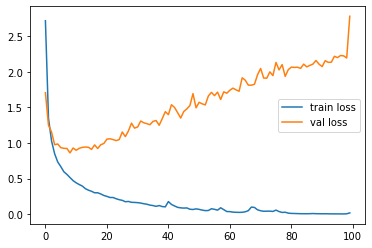

In [173]:
# plot some data

# loss
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

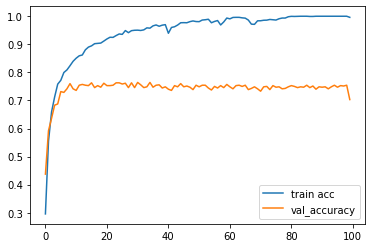

In [174]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [175]:
from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

ModuleNotFoundError: No module named 'util'